<a href="https://colab.research.google.com/github/HughYau/Research-with-Python/blob/main/Green%20Multiplier/Optimal_Policy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import weibull_min
from interpolation import interp
from quantecon.optimize.scalar_maximization import brent_max
from scipy.optimize import minimize_scalar
from collections import Counter
from matplotlib.ticker import MaxNLocator
from numba import njit, jit, njit, prange, float64, int32, typeof
from numba.experimental import jitclass
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

In [ ]:
ddcm_para = [
             ('t',int32),
             ('alpha',float64),
             ('beta',float64),
             ('delta',float64),
             ('gamma',float64),
             ('A',int32),
             ('var1',float64),
             ('var2',float64),
             ('truelambda',float64),
             ('zeta',float64),
             ('epsilon',float64),
             ('AFE',float64[:]),
             ('EAFE',float64[:]),
             ('VMT',float64),
             ('y',float64),
             ('r',float64),
             ('bt',float64),
             ('vat',float64),
             ('sub',float64[:]),
             ('cha',float64),
             ('shocks',float64[:,::1]),
             ('transition',float64[:,::1])
]

@jitclass(ddcm_para)
class DDCM:
    def __init__(self,
                 ifbt = 0,
                 bev_tax= 1.94,
                 phev_tax= 0.85,
                 t = 7,
                 epsilon = 1,
                 alpha = 2,
                 beta=0.8, 
                 delta = 0.02, 
                 gamma = 0.34,
                 A = 20,
                 var1 = 0.2,
                 var2 = 0.2,
                 truelambda = 0.2,
                 zeta = 1.7,
                 r = 0.05,
                 shocks = np.array([[105761.01203155,   7515.46061925],
                           [104044.59375342,   8558.00847766],
                           [102356.03159778,   9745.17901352],
                           [109349.77977224,   7582.17502758],
                           [107575.11860831,   8633.97753677],
                           [105829.25880323,   9831.68653247],
                           [113060.32446693,   7649.48165673],
                           [111225.44407274,   8710.62096983],
                           [109420.34234828,   9918.96197481]]),
                 transition = np.array([[1.97170195e-01, 4.46763023e-01, 1.38531452e-01, 2.89016362e-02,
                                6.54874961e-02, 2.03062417e-02, 2.59142361e-02, 5.87184208e-02,
                                1.82072994e-02],
                               [7.40998999e-02, 3.42063659e-01, 3.65482201e-01, 1.09625370e-02,
                                5.06058109e-02, 5.40704127e-02, 9.73741194e-03, 4.49503273e-02,
                                4.80277403e-02],
                               [2.66343353e-03, 1.34830014e-01, 6.43333900e-01, 3.97663163e-04,
                                2.01307558e-02, 9.60527797e-02, 3.49943580e-04, 1.77150649e-02,
                                8.45264452e-02],
                               [1.13618061e-01, 7.97603087e-02, 1.86765138e-02, 3.08931475e-01,
                                2.16871064e-01, 5.07820931e-02, 1.13246005e-01, 7.94991241e-02,
                                1.86153553e-02],
                               [4.48200448e-02, 1.22067362e-01, 4.48200458e-02, 1.22067361e-01,
                                3.32450377e-01, 1.22067364e-01, 4.48200431e-02, 1.22067358e-01,
                                4.48200442e-02],
                               [1.86153553e-02, 7.94991211e-02, 1.13246002e-01, 5.07820943e-02,
                                2.16871061e-01, 3.08931473e-01, 1.86765152e-02, 7.97603119e-02,
                                1.13618066e-01],
                               [8.45264525e-02, 1.77150659e-02, 3.49943590e-04, 9.60527754e-02,
                                2.01307543e-02, 3.97663123e-04, 6.43333902e-01, 1.34830010e-01,
                                2.66343338e-03],
                               [4.80277339e-02, 4.49503235e-02, 9.73741061e-03, 5.40704161e-02,
                                5.06058167e-02, 1.09625377e-02, 3.65482194e-01, 3.42063669e-01,
                                7.40998982e-02],
                               [1.82073008e-02, 5.87184255e-02, 2.59142379e-02, 2.03062428e-02,
                                6.54874999e-02, 2.89016376e-02, 1.38531450e-01, 4.46763016e-01,
                                1.97170189e-01]])
             ):

        self.t,self.epsilon,self.delta, self.beta, self.gamma,self.alpha,self.A,self.var1,self.var2,self.truelambda,self.zeta,self.r = t,epsilon,delta, beta, gamma,alpha,A,var1,var2,truelambda,zeta,r
        self.shocks = shocks
        self.transition = transition
        

        
        INC = np.array([18331,20167,21966,23821,25974,28228,30733,32189,35128])
        self.AFE = np.array([6.79,6.99,7.22,7.33,7.38,7.54,7.71,7.77,7.89,8,8.06,8.65,9.15,9.65,10.15,10.65,11.15,11.65,12.15,12.65,13.15])
        self.EAFE = np.array([14.7,19])
        self.VMT = 150
        N = np.array([2.98,2.97,3.1,3.11,3.03,3,2.92,2.92,3])
        VAT = np.array([0.17,0.17,0.17,0.17,0.17,0.16,0.13,0.13,0.13,0.13,0.13])

        CHARGE = np.array([2.2528,3.0914,6.6,23,44.6,77.7,121.9,168.1,261.7])
        self.y = self.epsilon*N[self.t]*INC[self.t]+80000
        self.vat = VAT[self.t]
        self.sub = np.array([0,bev_tax,phev_tax])
        self.bt = ifbt*0.1
        self.cha = CHARGE[self.t]
        
    def F(self,i,a,e):
        O = e[1]/1000
        if i == 0:
            F = 0.09*self.y
        elif i == 1:
            F = self.AFE[a-1]*self.VMT*0.732*O
        elif i == 2:
            F = self.EAFE[i-2]*self.VMT*0.6
        else:
            F = (self.EAFE[i-2]*0.6+self.AFE[a-1]*0.732*O)*self.VMT/2

        return F


    def constraint(self,c,i,a,e):
        P0 = e[0]
        def Q(i,a):
            scrapdis = np.array([0.806225  , 0.756255  , 0.695555  , 0.62868824, 0.5709375 ])
            scrapEV = np.array([0.612853333 ,0.62882])
            if i == 1:
                if a < 6:
                    Q = P0*scrapdis[i]
                else:
                    Q = 10000
            elif i == 2 or i == 3:
                if a == 1:
                    Q = P0*scrapEV[i-2]
                else:
                    Q = 0
            else:
                Q = 0

            return Q
        if c == 0:
            con = self.y - self.F(i,a,e)
        elif c == 4:
            con = self.y - self.F(0,a,e)+Q(i,a)
        else:
            P = P0*(1+self.bt+self.vat)/(1+self.vat)-self.sub[c-1]*10000
            con = self.y - self.F(c,1,e)-P+Q(i,a)

        return con

    def utility(self,c,i,a,e):
        aveage = np.array([10.5,10.5,12.1,12.1,12.9,12.9,12.9,12.9,12.9])
        cha = np.array([0,self.cha**self.var1,self.cha**self.var2])
        C = self.constraint(c,i,a,e)
        if C < 0:
            C = 10
        if c == 0:
            if i == 0:
                u = (C/self.truelambda)**(1-self.zeta)/(1-self.zeta)+self.alpha
            else:
#                 u = 1/(1+np.exp(self.gamma*(a-aveage[self.t])))+(C/self.truelambda)**(1-self.zeta)/(1-self.zeta)
                u = a**(-self.gamma)+(C/self.truelambda)**(1-self.zeta)/(1-self.zeta)+self.alpha
        elif c == 4:
            u = (C/self.truelambda)**(1-self.zeta)/(1-self.zeta)

        else:
            u = 1+(C/self.truelambda)**(1-self.zeta)/(1-self.zeta)+cha[c-1]

        return u

@jit(nopython = True)
def T(w,ddcm):
        Tw = np.zeros((4,ddcm.A,len(ddcm.shocks)))
        flag = np.asarray(Tw)
        for i in range(4):
            for k,e in enumerate(ddcm.shocks):
                if i == 0:
                    keep = ddcm.utility(0,0,0,e) + ddcm.beta*np.dot(ddcm.transition[k],w[0][0])
                    replace1 = ddcm.utility(1,0,1,e) + ddcm.beta*((1-ddcm.delta)*np.dot(ddcm.transition[k],w[1][2])+ddcm.delta*np.dot(ddcm.transition[k],w[0][0]))
                    replace2 = ddcm.utility(2,0,1,e) + ddcm.beta*((1-ddcm.delta)*np.dot(ddcm.transition[k],w[2][2])+ddcm.delta*np.dot(ddcm.transition[k],w[0][0]))
                    replace3 = ddcm.utility(3,0,1,e) + ddcm.beta*((1-ddcm.delta)*np.dot(ddcm.transition[k],w[3][2])+ddcm.delta*np.dot(ddcm.transition[k],w[0][0]))
                    Tw[0][0][k] = max(keep,replace1,replace2,replace3)


                else:
                    for j in range(1,ddcm.A-1):
                        if i == 1:
                            keep = ddcm.utility(0,1,j,e) + ddcm.beta*((1-ddcm.delta)*np.dot(ddcm.transition[k],w[i][j+1])+ddcm.delta*np.dot(ddcm.transition[k],w[0][0]))
                            replace1 = ddcm.utility(1,1,1,e) + ddcm.beta*((1-ddcm.delta)*np.dot(ddcm.transition[k],w[1][2])+ddcm.delta*np.dot(ddcm.transition[k],w[0][0]))
                            replace2 = ddcm.utility(2,1,1,e) + ddcm.beta*((1-ddcm.delta)*np.dot(ddcm.transition[k],w[2][2])+ddcm.delta*np.dot(ddcm.transition[k],w[0][0]))
                            replace3 = ddcm.utility(3,1,1,e) + ddcm.beta*((1-ddcm.delta)*np.dot(ddcm.transition[k],w[3][2])+ddcm.delta*np.dot(ddcm.transition[k],w[0][0]))
                            scrap = ddcm.utility(4,1,0,e)+ ddcm.beta*np.dot(ddcm.transition[k],w[0][0])
                            
                            Tw[i][j][k] = max(keep,replace1,replace2,replace3,scrap)

                        else:
                            keep = ddcm.utility(0,i,j,e) + ddcm.beta*((1-ddcm.delta)*np.dot(ddcm.transition[k],w[i][j+1])+ddcm.delta*np.dot(ddcm.transition[k],w[0][0]))
                            scrap = ddcm.utility(4,i,0,e)+ ddcm.beta*np.dot(ddcm.transition[k],w[0][0])
                            
                            Tw[i][j][k] = max(keep,scrap)
                            

        return Tw
    
    
@jit(nopython = True)
def Prob(ddcm,w):
    Prk = np.zeros((4,ddcm.A,len(ddcm.shocks)))
    Prr1 = np.zeros((4,ddcm.A,len(ddcm.shocks)))
    Prr2 = np.zeros((4,ddcm.A,len(ddcm.shocks)))
    Prr3 = np.zeros((4,ddcm.A,len(ddcm.shocks)))
    Prs = np.zeros((4,ddcm.A,len(ddcm.shocks)))

    for i in range(4):
        for k,e in enumerate(ddcm.shocks):
            if i == 0:
                keep = ddcm.utility(0,0,0,e) + ddcm.beta*np.dot(ddcm.transition[k],w[0][0])
                replace1 = ddcm.utility(1,0,1,e) + ddcm.beta*((1-ddcm.delta)*np.dot(ddcm.transition[k],w[1][2])+ddcm.delta*np.dot(ddcm.transition[k],w[0][0]))
                replace2 = ddcm.utility(2,0,1,e) + ddcm.beta*((1-ddcm.delta)*np.dot(ddcm.transition[k],w[2][2])+ddcm.delta*np.dot(ddcm.transition[k],w[0][0]))
                replace3 = ddcm.utility(3,0,1,e) + ddcm.beta*((1-ddcm.delta)*np.dot(ddcm.transition[k],w[3][2])+ddcm.delta*np.dot(ddcm.transition[k],w[0][0]))

                Prk[0][0][k] = np.exp(keep)/(np.exp(keep)+np.exp(replace1)+np.exp(replace2)+np.exp(replace3))
                Prr1[0][0][k] = np.exp(replace1)/(np.exp(keep)+np.exp(replace1)+np.exp(replace2)+np.exp(replace3))
                Prr2[0][0][k] = np.exp(replace2)/(np.exp(keep)+np.exp(replace1)+np.exp(replace2)+np.exp(replace3))
                Prr3[0][0][k] = np.exp(replace3)/(np.exp(keep)+np.exp(replace1)+np.exp(replace2)+np.exp(replace3))


            else:
                for j in range(1,ddcm.A-1):
                    if i == 1:
                        keep = ddcm.utility(0,1,j,e) + ddcm.beta*((1-ddcm.delta)*np.dot(ddcm.transition[k],w[i][j+1])+ddcm.delta*np.dot(ddcm.transition[k],w[0][0]))
                        replace1 = ddcm.utility(1,1,1,e) + ddcm.beta*((1-ddcm.delta)*np.dot(ddcm.transition[k],w[1][2])+ddcm.delta*np.dot(ddcm.transition[k],w[0][0]))
                        replace2 = ddcm.utility(2,1,1,e) + ddcm.beta*((1-ddcm.delta)*np.dot(ddcm.transition[k],w[2][2])+ddcm.delta*np.dot(ddcm.transition[k],w[0][0]))
                        replace3 = ddcm.utility(3,1,1,e) + ddcm.beta*((1-ddcm.delta)*np.dot(ddcm.transition[k],w[3][2])+ddcm.delta*np.dot(ddcm.transition[k],w[0][0]))
                        scrap = ddcm.utility(4,1,0,e)+ ddcm.beta*np.dot(ddcm.transition[k],w[0][0])

                        Prk[1][j][k] = np.exp(keep)/(np.exp(keep)+np.exp(replace1)+np.exp(replace2)+np.exp(replace3)+np.exp(scrap))
                        Prr1[1][j][k] = np.exp(replace1)/(np.exp(keep)+np.exp(replace1)+np.exp(replace2)+np.exp(replace3)+np.exp(scrap))
                        Prr2[1][j][k] = np.exp(replace2)/(np.exp(keep)+np.exp(replace1)+np.exp(replace2)+np.exp(replace3)+np.exp(scrap))
                        Prr3[1][j][k] = np.exp(replace3)/(np.exp(keep)+np.exp(replace1)+np.exp(replace2)+np.exp(replace3)+np.exp(scrap))
                        Prs[1][j][k] = np.exp(scrap)/(np.exp(keep)+np.exp(replace1)+np.exp(replace2)+np.exp(replace3)+np.exp(scrap))

                    else:
                        keep = ddcm.utility(0,i,j,e) + ddcm.beta*((1-ddcm.delta)*np.dot(ddcm.transition[k],w[i][j+1])+ddcm.delta*np.dot(ddcm.transition[k],w[0][0]))
                        scrap = ddcm.utility(4,i,0,e)+ ddcm.beta*np.dot(ddcm.transition[k],w[0][0])

                        Prk[i][j][k] = np.exp(keep)/(np.exp(keep)+np.exp(scrap))
                        Prs[i][j][k] = np.exp(scrap)/(np.exp(keep)+np.exp(scrap))


    return  Prk,Prr1 ,Prr2,Prr3 , Prs 


def solve_model(v,ddcm ,
                tol=1e-4,
                max_iter=1000,
                verbose=False,
                print_skip=1):


    i = 0
    error = tol + 1

    while i < max_iter and error > tol:
        v_new = T(v,ddcm)
        error = np.max(np.abs(v - v_new))
        i += 1
        if verbose and i % print_skip == 0:
            print(f"Error at iteration {i} is {error}.")
        v = v_new

    if i == max_iter:
        print("Failed to converge!")

    if verbose and i < max_iter:
        print(f"\nConverged in {i} iterations.")

    return v_new



In [ ]:
stock = np.array([10933.09,12670.14,14598.11,16284.45,18574.54,20906.67,23231.22,25376.38,273409.175,301510])#2012
evstock = np.array([0,6,21.64,58.32,91.28,153.4,260.78,380.87,492.02,784])#2012
agepdf = np.array([[0.201 , 0.18  , 0.169 , 0.16  , 0.164 , 0.1466, 0.1372, 0.1278,
    0.1184, 0.109 ],
   [0.168 , 0.161 , 0.152 , 0.145 , 0.137 , 0.1292, 0.1214, 0.1136,
    0.1058, 0.098 ],
   [0.172 , 0.14  , 0.135 , 0.129 , 0.125 , 0.1087, 0.0982, 0.0877,
    0.0772, 0.0667],
   [0.129 , 0.14  , 0.117 , 0.115 , 0.109 , 0.1025, 0.096 , 0.0895,
    0.083 , 0.0765],
   [0.081 , 0.11  , 0.118 , 0.1   , 0.098 , 0.1086, 0.111 , 0.1134,
    0.1158, 0.1182],
   [0.069 , 0.066 , 0.092 , 0.099 , 0.083 , 0.1001, 0.1062, 0.1123,
    0.1184, 0.1245],
   [0.058 , 0.059 , 0.055 , 0.077 , 0.084 , 0.0876, 0.0946, 0.1016,
    0.1086, 0.1156],
   [0.042 , 0.047 , 0.048 , 0.046 , 0.064 , 0.0623, 0.0666, 0.0709,
    0.0752, 0.0795],
   [0.03  , 0.034 , 0.038 , 0.04  , 0.037 , 0.0418, 0.0438, 0.0458,
    0.0478, 0.0498],
   [0.024 , 0.024 , 0.027 , 0.031 , 0.032 , 0.0345, 0.0368, 0.0391,
    0.0414, 0.0437],
   [0.013 , 0.019 , 0.019 , 0.022 , 0.024 , 0.0269, 0.0294, 0.0319,
    0.0344, 0.0369],
   [0.006 , 0.011 , 0.015 , 0.015 , 0.017 , 0.0206, 0.0232, 0.0258,
    0.0284, 0.031 ],
   [0.004 , 0.005 , 0.008 , 0.012 , 0.011 , 0.0143, 0.0164, 0.0185,
    0.0206, 0.0227],
   [0.002 , 0.003 , 0.004 , 0.006 , 0.008 , 0.0091, 0.0106, 0.0121,
    0.0136, 0.0151],
   [0.001 , 0.001 , 0.002 , 0.003 , 0.004 , 0.0046, 0.0054, 0.0062,
    0.007 , 0.0078],
   [0.    , 0.    , 0.001 , 0.001 , 0.003 , 0.0026, 0.0032, 0.0038,
    0.0044, 0.005 ]])

def estimate_function(ifbt,bev_tax,phev_tax):
#     ifbt = 0
    ep = np.array([0.12963452764342645,
                    0.39477314210369746,
                    0.722465667274827,
                    1.1993295554449177,
                    2.376092686067955])
    t = 7
#     phev_tax = 0
    VAT = [0.17,0.17,0.17,0.17,0.17,0.16,0.13,0.13,0.13,0.13]
    price = np.array([104625.  , 103741.67, 103833.33, 105558.33, 105575.  , 105087.5 ,
        113700.  , 114675.  ])
#     theta = [7.33086700e+00, 1.17610371e+01, 1.95900904e-01, 6.91557514e-02,
#        8.72723806e+05, 2.13174732e+00]
    theta = [2.07139266e+01, 5.99218827e-01, 1.87930275e-01, 1.47336089e-01,
       1.11396624e+06, 1.71926020e+00]
    trstock = [stock[i] - evstock[i] for i in range(len(stock))]
    shocklist=[6,6,1,4,2,2,4,6]
    predsale = np.empty(2)
    predsale1 = np.empty(2)
    Pr = 0
    for e_i,e in enumerate(ep):
        k = shocklist[t]
        model = DDCM(ifbt = ifbt,bev_tax = bev_tax,phev_tax = phev_tax,t = t,epsilon = e,alpha = theta[0], beta=0.95, delta = 0.02, gamma = theta[1],A = 16,var1 = theta[2],var2 = theta[3],truelambda = theta[4],zeta = theta[5])
        w_guess = np.zeros((4,model.A,len(model.shocks)))
        w_star1 = w_inc = solve_model(w_guess,model, print_skip=100)
#         Pr = Prob(model,w_star1)
        Pr = Pr+np.asarray(Prob(model,w_star1))
    Pr = Pr/len(ep)
    for j in range (0,2):
        frac1 = 0
        frac2 = 0
        for a in range(1,15):
            frac1 += Pr[j+2][1][a+1][k]*(1-model.delta)*agepdf[a][t]
            frac2 += Pr[4][1][a+1][k]*agepdf[a][t]
        predsale[j] = frac1*trstock[t]+Pr[j+2][0][0][k]*trstock[t]*(model.delta+frac1+frac2)
        predsale1[j] = (Pr[j+2][0][0][k]*trstock[t]*(model.delta+frac1+frac2))*10e7
        
    
    cg1 = 55.3
    cg2 = 28.1
    gs = predsale[0]*bev_tax+predsale[1]*phev_tax
#     tax = (predsale[0]+predsale[1])*price[t]*(ifbt*0.1+VAT[t])/(10000*(1+VAT[t]))
    tax = (predsale[0]+predsale[1])*price[t]*((1-ifbt)*0.1)/(10000*(1+VAT[t]))
#     w = gs-tax+234.468573
    w = gs + tax
    c = (predsale[0]*cg1+predsale[1]*cg2-(predsale1[0]+predsale1[1])*209)*15/100
#     gm = (c-749.022329)/w
#     print(predsale)
    return c,w

In [ ]:
def estimate_function1(bev_tax):
    ifbt = 0
    ep = np.array([0.12963452764342645,
                    0.39477314210369746,
                    0.722465667274827,
                    1.1993295554449177,
                    2.376092686067955])
    t = 7
    phev_tax = 0
    VAT = [0.17,0.17,0.17,0.17,0.17,0.16,0.13,0.13,0.13,0.13]
    price = np.array([104625.  , 103741.67, 103833.33, 105558.33, 105575.  , 105087.5 ,
        113700.  , 114675.  ])
#     theta = [7.33086700e+00, 1.17610371e+01, 1.95900904e-01, 6.91557514e-02,
#        8.72723806e+05, 2.13174732e+00]
    theta = [2.07139266e+01, 5.99218827e-01, 1.87930275e-01, 1.47336089e-01,
       1.11396624e+06, 1.71926020e+00]
    trstock = [stock[i] - evstock[i] for i in range(len(stock))]
    shocklist=[6,6,1,4,2,2,4,6]
    predsale = np.empty(2)
    predsale1 = np.empty(2)
    Pr = 0
    for e_i,e in enumerate(ep):
        k = shocklist[t]
        model = DDCM(ifbt = ifbt,bev_tax = bev_tax,phev_tax = phev_tax,t = t,epsilon = e,alpha = theta[0], beta=0.95, delta = 0.02, gamma = theta[1],A = 16,var1 = theta[2],var2 = theta[3],truelambda = theta[4],zeta = theta[5])
        w_guess = np.zeros((4,model.A,len(model.shocks)))
        w_star1 = w_inc = solve_model(w_guess,model, print_skip=100)
#         Pr = Prob(model,w_star1)
        Pr = Pr+np.asarray(Prob(model,w_star1))
    Pr = Pr/len(ep)
    for j in range (0,2):
        frac1 = 0
        frac2 = 0
        for a in range(1,15):
            frac1 += Pr[j+2][1][a+1][k]*(1-model.delta)*agepdf[a][t]
            frac2 += Pr[4][1][a+1][k]*agepdf[a][t]
        predsale[j] = frac1*trstock[t]+Pr[j+2][0][0][k]*trstock[t]*(model.delta+frac1+frac2)
        predsale1[j] = (Pr[j+2][0][0][k]*trstock[t]*(model.delta+frac1+frac2))*10e7
        
    
    cg1 = 55.3
    cg2 = 28.1
    gs = predsale[0]*bev_tax+predsale[1]*phev_tax
#     tax = (predsale[0]+predsale[1])*price[t]*(ifbt*0.1+VAT[t])/(10000*(1+VAT[t]))
    tax = (predsale[0]+predsale[1])*price[t]*((1-ifbt)*0.1)/(10000*(1+VAT[t]))
#     w = gs-tax+234.468573
    w = gs + tax
    c = (predsale[0]*cg1+predsale[1]*cg2-(predsale1[0]+predsale1[1])*209)*15/100
#     gm = (c-749.022329)/w
#     print(predsale)
    return -(c-399.624943)/w

In [ ]:
N = 50
bev_tax = np.linspace(0,5,N)
phev_tax = np.linspace(0,2,N)
c = np.zeros((2,N,N))
w = np.zeros((2,N,N))
for i,btax in enumerate(bev_tax):
    for j,ptax in enumerate(phev_tax):
        for k in range(2):
            res = estimate_function(k,btax,ptax)
            c[k][i][j],w[k][i][j] = res[0],res[1]
# np.save('optimal_carbon_3d_new1.npy',c)
# np.save('optimal_w_3d_new1.npy',w)

In [ ]:
np.save('optimal_w_3d_new2.npy',w)

In [ ]:
minimize_scalar(estimate_function1,method = 'brent')

     fun: -1.0371530768516353
    nfev: 19
     nit: 15
 success: True
       x: 0.8231924319631744

In [ ]:
estimate_function(1,0.7096134930605741)

-80.51081636372072

In [ ]:
minimize_scalar(estimate_function,method = 'brent')

     fun: -1.9086137426290193
    nfev: 18
     nit: 14
 success: True
       x: 0.619978094277873

In [ ]:
estimate_function(0,0.619978094277873)

-206.93286573972574

In [ ]:
N = 50
bev_tax = np.linspace(0,5,N)
phev_tax = np.linspace(0,2,N)
c = np.zeros((2,N,N))
w = np.zeros((2,N,N))
j = 0
ptax = 0.5
for i,btax in enumerate(bev_tax):
#     for j,ptax in enumerate(phev_tax):
    for k in range(2):
        res = estimate_function(k,btax,ptax)
        c[k][i][j],w[k][i][j] = res[0],res[1]

In [ ]:
bev_tax

array([0.        , 0.08163265, 0.16326531, 0.24489796, 0.32653061,
       0.40816327, 0.48979592, 0.57142857, 0.65306122, 0.73469388,
       0.81632653, 0.89795918, 0.97959184, 1.06122449, 1.14285714,
       1.2244898 , 1.30612245, 1.3877551 , 1.46938776, 1.55102041,
       1.63265306, 1.71428571, 1.79591837, 1.87755102, 1.95918367,
       2.04081633, 2.12244898, 2.20408163, 2.28571429, 2.36734694,
       2.44897959, 2.53061224, 2.6122449 , 2.69387755, 2.7755102 ,
       2.85714286, 2.93877551, 3.02040816, 3.10204082, 3.18367347,
       3.26530612, 3.34693878, 3.42857143, 3.51020408, 3.59183673,
       3.67346939, 3.75510204, 3.83673469, 3.91836735, 4.        ])

In [ ]:
estimate_function(1,2,0.4)

(1074.3732949495293, -88.75660590297005)

In [ ]:
c[1][5][2]

731.512593852735

In [ ]:
bev_tax

array([0.        , 0.004004  , 0.00800801, 0.01201201, 0.01601602,
       0.02002002, 0.02402402, 0.02802803, 0.03203203, 0.03603604,
       0.04004004, 0.04404404, 0.04804805, 0.05205205, 0.05605606,
       0.06006006, 0.06406406, 0.06806807, 0.07207207, 0.07607608,
       0.08008008, 0.08408408, 0.08808809, 0.09209209, 0.0960961 ,
       0.1001001 , 0.1041041 , 0.10810811, 0.11211211, 0.11611612,
       0.12012012, 0.12412412, 0.12812813, 0.13213213, 0.13613614,
       0.14014014, 0.14414414, 0.14814815, 0.15215215, 0.15615616,
       0.16016016, 0.16416416, 0.16816817, 0.17217217, 0.17617618,
       0.18018018, 0.18418418, 0.18818819, 0.19219219, 0.1961962 ,
       0.2002002 , 0.2042042 , 0.20820821, 0.21221221, 0.21621622,
       0.22022022, 0.22422422, 0.22822823, 0.23223223, 0.23623624,
       0.24024024, 0.24424424, 0.24824825, 0.25225225, 0.25625626,
       0.26026026, 0.26426426, 0.26826827, 0.27227227, 0.27627628,
       0.28028028, 0.28428428, 0.28828829, 0.29229229, 0.29629

In [ ]:
np.save('optimal_carbon.npy',c)
np.save('optimal_w.npy',w)

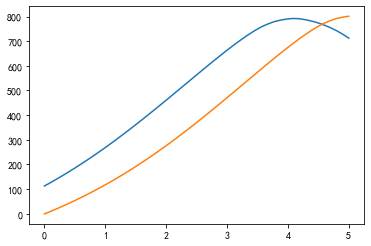

In [ ]:
plt.plot(bev_tax,c[0,:,0]-399.624943)
plt.plot(bev_tax,c[1,:,0]-399.624943)

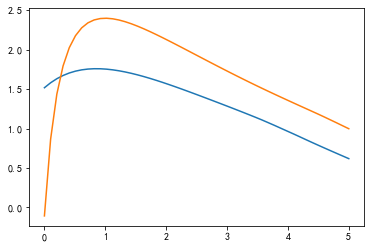

In [ ]:
plt.plot(bev_tax,(c[0,:,0]-399.624943)/(w[0,:,0]+216.707552))
plt.plot(bev_tax,(c[1,:,0]-399.624943)/(w[1,:,0]+216.707552))

In [ ]:
np.argmax((c[1]-666.416089)/(w[1]+229.468573))

299

In [ ]:
bev_tax[299]

1.197197197197197

In [ ]:
gm[1]+220.468573

array([  3.76102136,   4.78725855,   5.83604955,   6.9077499 ,
         8.00272077,   9.12132898,  10.26394708,  11.43095336,
        12.62273192,  13.8396727 ,  15.08217148,  16.35062996,
        17.64545578,  18.9670625 ,  20.31586968,  21.69230285,
        23.09679356,  24.52977935,  25.9917038 ,  27.48301648,
        29.004173  ,  30.55563496,  32.13786994,  33.75135153,
        35.39655923,  37.07397849,  38.78410065,  40.52742289,
        42.30444823,  44.11568541,  45.96164893,  47.84285891,
        49.75984106,  51.7131266 ,  53.70325221,  55.73075993,
        57.79619703,  59.90011602,  62.04307443,  64.22563481,
        66.44836455,  68.71183577,  71.01662526,  73.36331426,
        75.7524884 ,  78.18473751,  80.6606555 ,  83.18084021,
        85.74589323,  88.35641978,  91.01302848,  93.71633123,
        96.466943  ,  99.26548167, 102.11256781, 105.00882451,
       107.95487719, 110.95135336, 113.99888244, 117.09809555,
       120.24962527, 123.45410547, 126.71217101, 130.02

In [ ]:
gm[1]

array([-0.22987957,  4.56996771,  4.540503  ,  4.51128457,  4.4823088 ,
        4.45357179,  4.42506971,  4.39679876,  4.36875526,  4.34093559,
        4.31333621,  4.28595368,  4.25878463,  4.23182577,  4.2050739 ,
        4.17852589,  4.15217868,  4.12602931,  4.10007488,  4.07431256,
        4.0487396 ,  4.02335332,  3.99815112,  3.97313046,  3.94828886,
        3.92362392,  3.89913331,  3.87481476,  3.85066606,  3.82668507,
        3.8028697 ,  3.77921793,  3.7557278 ,  3.73239741,  3.7092249 ,
        3.6862085 ,  3.66334645,  3.64063708,  3.61807876,  3.59566991,
        3.573409  ,  3.55129454,  3.52932512,  3.50749933,  3.48581584,
        3.46427336,  3.44287063,  3.42160645,  3.40047963,  3.37948905,
        3.35863362,  3.33791229,  3.31732403,  3.29686787,  3.27654285,
        3.25634806,  3.23628261,  3.21634566,  3.19653637,  3.17685396,
        3.15729766,  3.13786671,  3.11856042,  3.09937809,  3.08031905,
        3.06138265,  3.04256828,  3.02387532,  3.0053032 ,  2.98

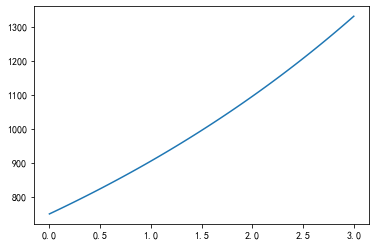

In [ ]:
plt.plot(bev_tax,c)

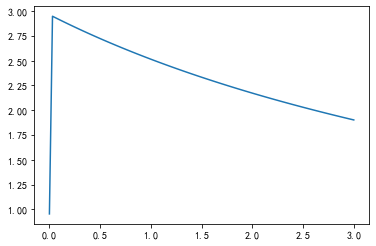

In [ ]:
plt.plot(bev_tax,gm)